In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

Vamos abrir os dados da queda livre. O arquivo csv contém 3 colunas: time (em segundos), position (em metros) e experiment (qual filmagem é). 

In [55]:
dfQuedaLivre = pd.read_csv('DATA/freeFall.csv')
dfPendulo = pd.read_csv('DATA/pendulum.csv')
dfAtrito= pd.read_csv('DATA/atrito.csv')
#converter para radianos e colocar o "270" em 0
dfPendulo['angle'] = 270 - dfPendulo['angle']
dfPendulo['angle'] = dfPendulo['angle']*(math.pi/180)

Vamos plotar o gráfico da posição em função do tempo

In [56]:
def plotCol(df, xlabel, ylabel, colName, titleName):
    experiments = df['experiment'].unique()
    fig, axs = plt.subplots(len(experiments), figsize = (5, 20))
    
    for ax,ex in zip(axs, experiments):
        dff = df.loc[df['experiment'] == ex]
        x = dff.time
        y = dff[colName]

        ax.set_title(f'Experimento {ex} ({titleName})')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)


        ax.plot(x, y, zorder = 1)
        ax.scatter(x, y, c = 'tab:orange', zorder = 2)
    
    fig.tight_layout()
    plt.show()

In [57]:
def createVelCol(df, positionName):
    velocities = []
    experiments = df['experiment'].unique()
    
    for ex in experiments:
        dff = df.loc[df['experiment'] == ex]
        
        indices = list(dff.index.values)
        indices.pop()
        
        for i in indices:
            v = (dff[positionName][i+1] - dff[positionName][i]) / (dff.time[i+1] - dff.time[i])
            velocities.append(v)
        
        velocities.append(np.nan)
        
    df['velocity'] = velocities
            

def createAccCol(df):
    accs = []
    experiments = df['experiment'].unique()

    for ex in experiments:
        dff = df.loc[df['experiment'] == ex]

        indices = list(dff.index.values)
        indices.pop()
        indices.pop()

        for i in indices:
            a = (dff['velocity'][i+1] - dff['velocity'][i]) / (dff.time[i+1] - dff.time[i])
            accs.append(a)

        accs.append(np.nan)
        accs.append(np.nan)

    df['acceleration'] = accs


In [58]:
createVelCol(dfQuedaLivre, 'position')
createAccCol(dfQuedaLivre)

createVelCol(dfPendulo, 'angle')
createAccCol(dfPendulo)

createVelCol(dfAtrito, 'distance')
createAccCol(dfAtrito)

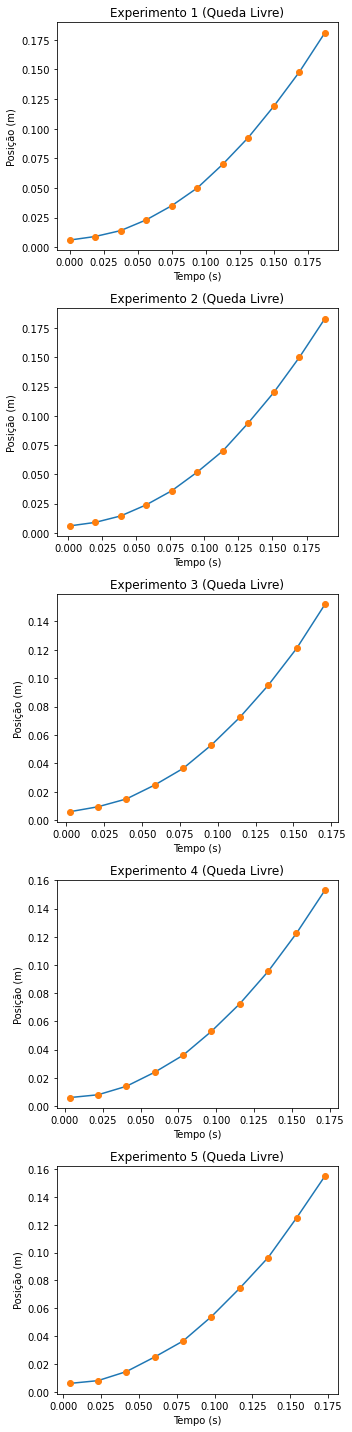

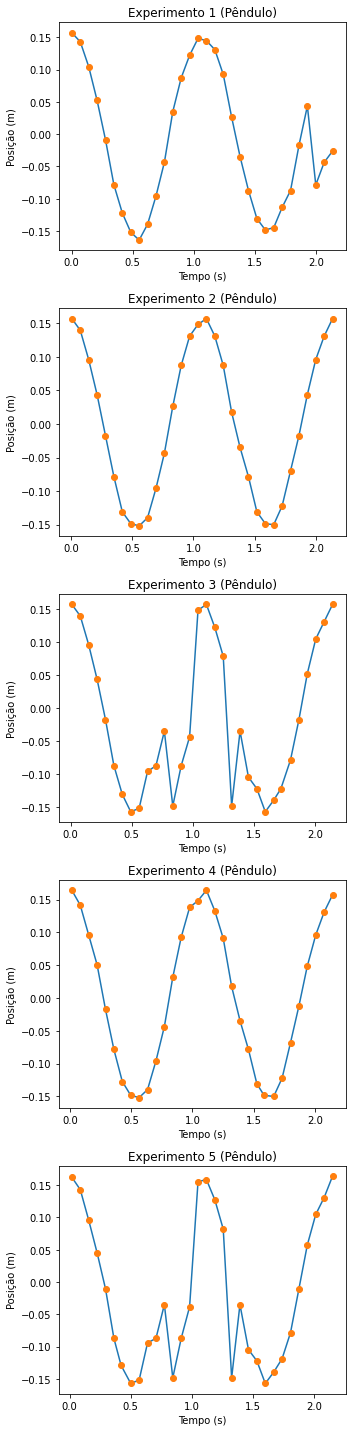

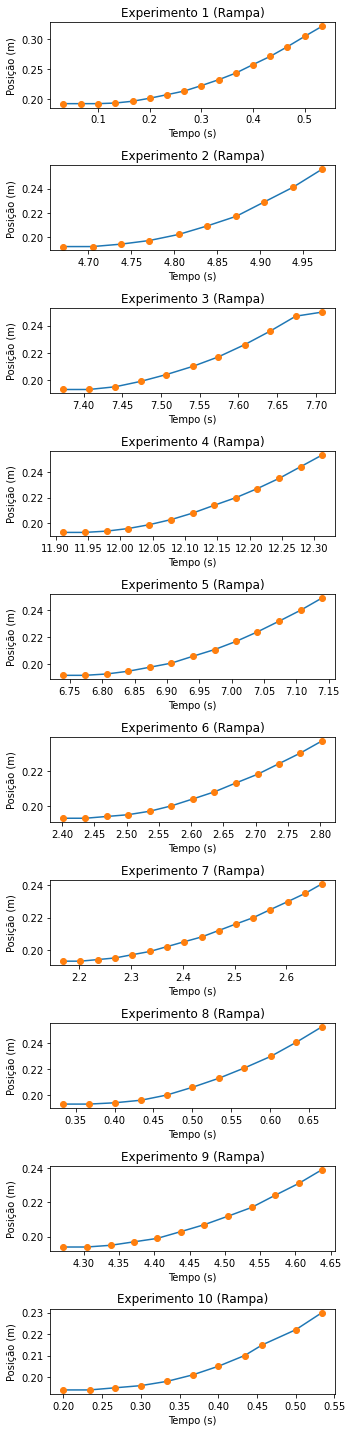

In [59]:
plotCol(dfQuedaLivre, 'Tempo (s)', 'Posição (m)', 'position', 'Queda Livre')
plotCol(dfPendulo, 'Tempo (s)', 'Posição (m)', 'angle', 'Pêndulo')
plotCol(dfAtrito, 'Tempo (s)', 'Posição (m)', 'distance', 'Rampa')

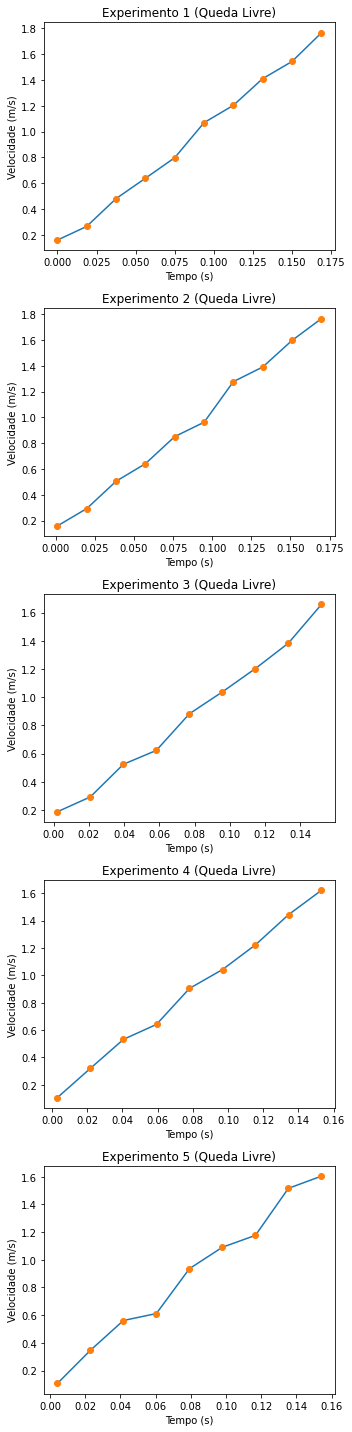

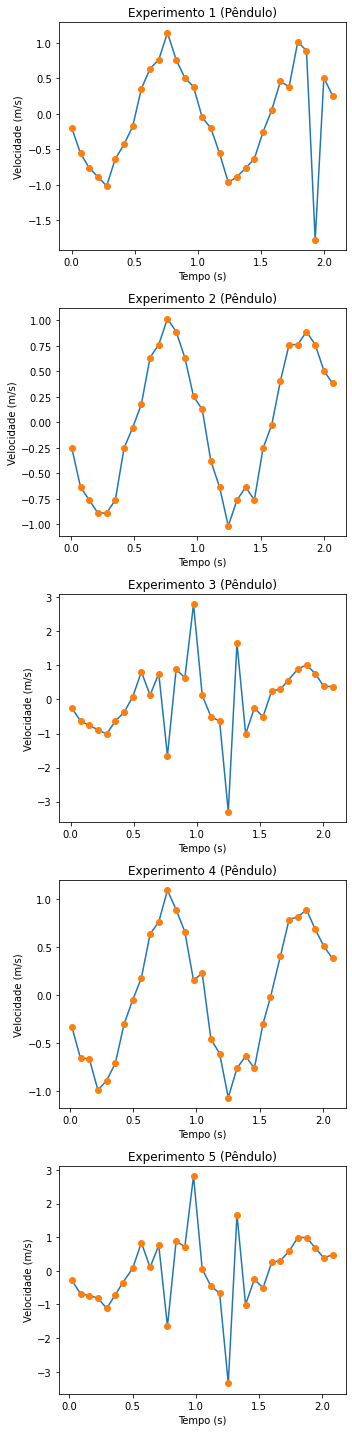

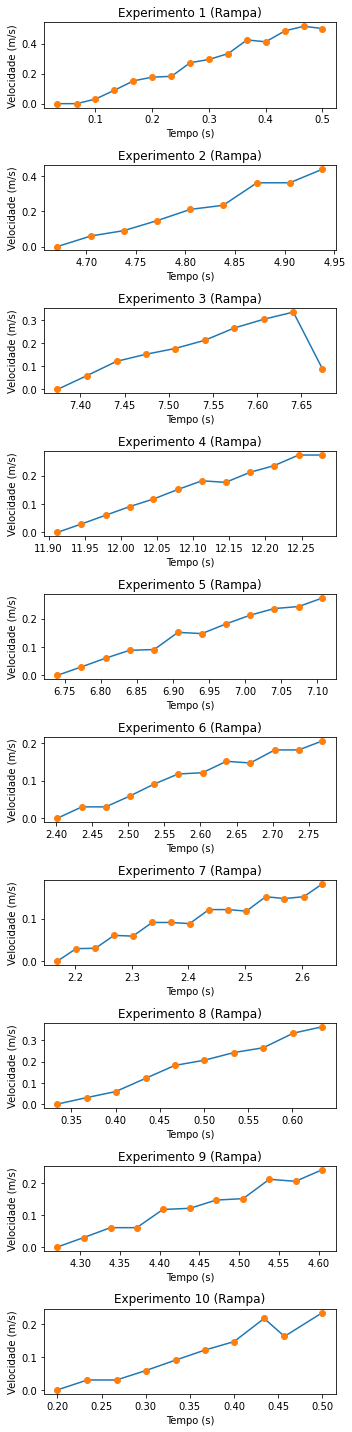

In [60]:
plotCol(dfQuedaLivre, 'Tempo (s)', 'Velocidade (m/s)', 'velocity', 'Queda Livre')
plotCol(dfPendulo, 'Tempo (s)', 'Velocidade (m/s)', 'velocity', 'Pêndulo')
plotCol(dfAtrito, 'Tempo (s)', 'Velocidade (m/s)', 'velocity', 'Rampa')

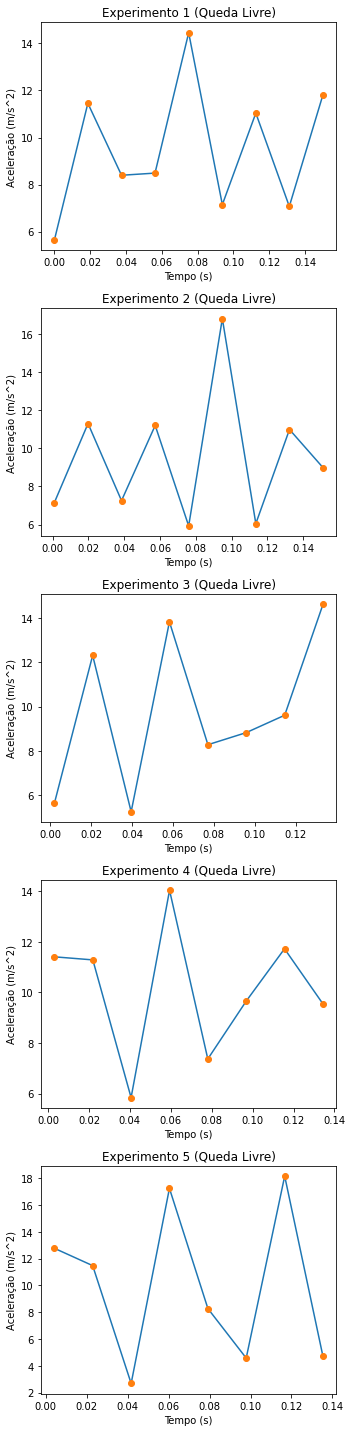

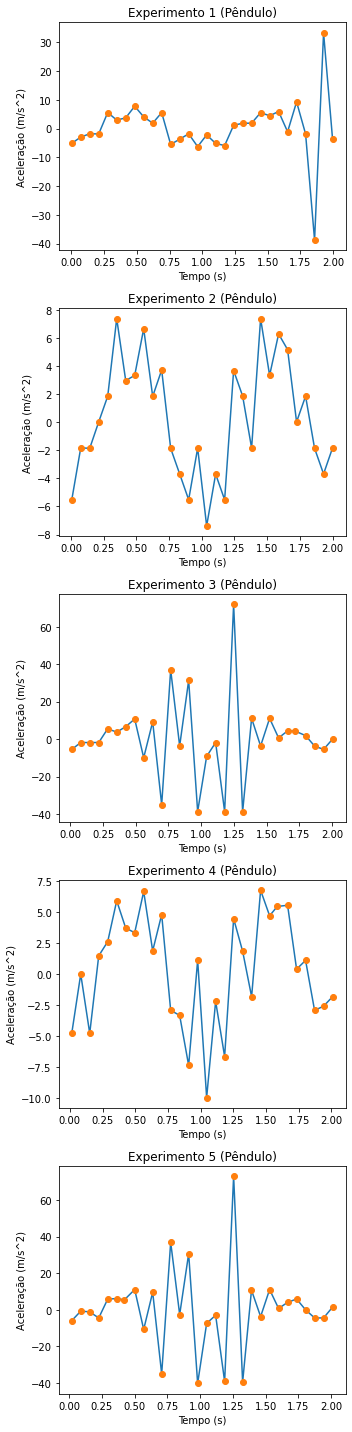

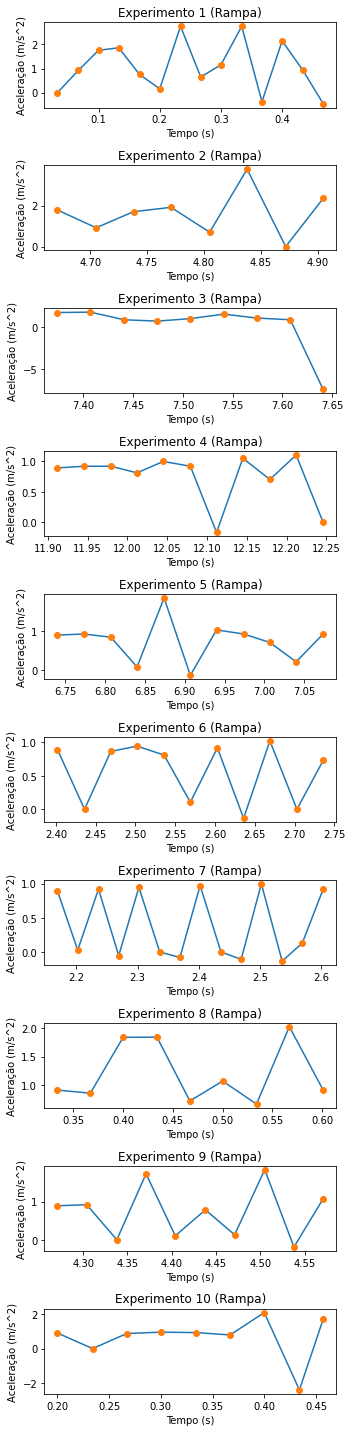

In [52]:
plotCol(dfQuedaLivre, 'Tempo (s)', 'Aceleração (m/s^2)', 'acceleration', 'Queda Livre')
plotCol(dfPendulo, 'Tempo (s)', 'Aceleração (m/s^2)', 'acceleration', 'Pêndulo')
plotCol(dfAtrito, 'Tempo (s)', 'Aceleração (m/s^2)', 'acceleration', 'Rampa')

In [53]:
dfQuedaLivre.to_csv('DATA/ffWVel.csv', index = False)
dfPendulo.to_csv('DATA/pWVel.csv', index = False)